# 한국어 챗봇 만들기

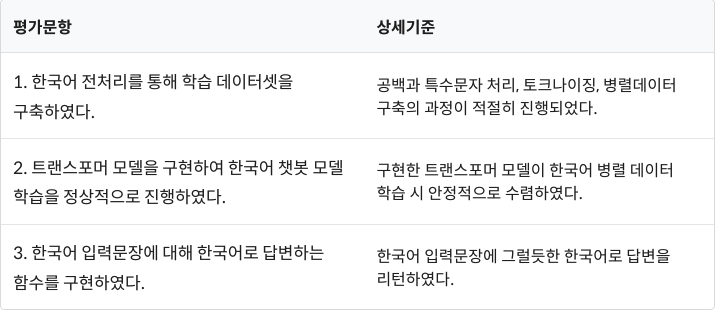

In [1]:
%%capture
# !mkdir -p ~/aiffel/transformer_chatbot/data/
# !ln -s ~/data/* ~/aiffel/transformer_chatbot/data/
# !pip install git+https://github.com/haven-jeon/PyKoSpacing.git
# !pip install git+https://github.com/ssut/py-hanspell.git

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from hanspell import spell_checker

In [3]:
data_path = os.getenv('HOME')+'/aiffel/transformer_chatbot/data/ChatbotData .csv'
data = pd.read_csv(data_path)
data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


## 데이터 전처리

In [4]:
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


In [5]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
#     sentence = spell_checker.check(sentence)
#     sentence = sentence.checked

    return sentence

In [6]:
def load_conversations(questions, answers):
    inputs, outputs = [], []
    
    for question, answer in zip(questions, answers):
        inputs.append(preprocess_sentence(question))
        outputs.append(preprocess_sentence(answer))
        
    return inputs, outputs

In [7]:
pre_q,pre_a = data['Q'], data['A']
questions, answers = load_conversations(data['Q'], data['A'])
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [8]:
n = 10
print('전처리 전의 질문 샘플: {}'.format(pre_q[n]))
print('전처리 전의 답변 샘플: {}'.format(pre_a[n]))
print('전처리 후의 질문 샘플: {}'.format(questions[n]))
print('전처리 후의 답변 샘플: {}'.format(answers[n]))

전처리 전의 질문 샘플: SNS보면 나만 빼고 다 행복해보여
전처리 전의 답변 샘플: 자랑하는 자리니까요.
전처리 후의 질문 샘플: sns보면 나만 빼고 다 행복해보여
전처리 후의 답변 샘플: 자랑하는 자리니까요 .


## SubwordTextEncoder 사용해보기


In [9]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [10]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print('START_TOKEN의 번호 :', [tokenizer.vocab_size])
print('END_TOKEN의 번호 :', [tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8173]
END_TOKEN의 번호 : [8174]


In [11]:
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8175


In [12]:
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5763, 610, 2492, 4164]
정수 인코딩 후의 21번째 답변 샘플: [2356, 7513, 7, 6276, 97, 1]


In [13]:
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [14]:
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [15]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :', (VOCAB_SIZE))
print('필터링 후의 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8175
필터링 후의 샘플 개수: 11823
필터링 후의 샘플 개수: 11823


## Transformer함수 정의

In [16]:
# PositionalEncoding
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) /
                            tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [17]:
# scaled_dot_product_attention
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    if mask is not None:
        logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

In [18]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention = scaled_dot_product_attention(
            query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        outputs = self.dense(concat_attention)

        return outputs

In [19]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - \
        tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })

    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

## 학습 및 평가

In [20]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [21]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # encoder
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # decoder
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(
        units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [22]:
tf.keras.backend.clear_session()

NUM_LAYERS = 6  # 인코더와 디코더의 층의 개수
D_MODEL = 512  # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8  # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512  # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1  # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()


Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    13653504    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [23]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [24]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [25]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [26]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 56s 205ms/step - loss: 1.3504 - accuracy: 0.0230
Epoch 2/50
185/185 [==============================] - 38s 208ms/step - loss: 1.0760 - accuracy: 0.0493
Epoch 3/50
185/185 [==============================] - 39s 210ms/step - loss: 0.9815 - accuracy: 0.0506
Epoch 4/50
185/185 [==============================] - 39s 212ms/step - loss: 0.9390 - accuracy: 0.0527
Epoch 5/50
185/185 [==============================] - 40s 214ms/step - loss: 0.9051 - accuracy: 0.0549
Epoch 6/50
185/185 [==============================] - 40s 216ms/step - loss: 0.8681 - accuracy: 0.0570
Epoch 7/50
185/185 [==============================] - 40s 216ms/step - loss: 0.8284 - accuracy: 0.0593
Epoch 8/50
185/185 [==============================] - 40s 217ms/step - loss: 0.7799 - accuracy: 0.0626
Epoch 9/50
185/185 [==============================] - 40s 218ms/step - loss: 0.7234 - accuracy: 0.0669
Epoch 10/50
185/185 [==============================] - 40s 217ms/step - l

## 문장 예측해보기

In [27]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    output_sequence = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

def sentence_generation(sentence):
    prediction = decoder_inference(sentence)

    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [28]:
sentence_generation("자기소개")

입력 : 자기소개
출력 : 원하는 게 점점 많아지는 세상이에요 .


'원하는 게 점점 많아지는 세상이에요 .'

In [29]:
sentence_generation("너는 취미가 뭐야?")

입력 : 너는 취미가 뭐야?
출력 : 누구든 받을 사람이 있을 거예요 . 친구들한테 연락해보세요 .


'누구든 받을 사람이 있을 거예요 . 친구들한테 연락해보세요 .'

In [30]:
sentence_generation("너는 누구니?")

입력 : 너는 누구니?
출력 : 저는 위로해드리는 로봇이에요 .


'저는 위로해드리는 로봇이에요 .'

In [31]:
sentence_generation("거울아 거울아")

입력 : 거울아 거울아
출력 : 헤어지세요 .


'헤어지세요 .'

In [33]:
sentence_generation("박지성을 알아?")

입력 : 박지성을 알아?
출력 : 당신이 버렸다고 생각하는 건 어떨까요 .


'당신이 버렸다고 생각하는 건 어떨까요 .'

In [34]:
sentence_generation("손흥민을 알아?")

입력 : 손흥민을 알아?
출력 : 괜찮은 척 하고 있던 걸 수도 있어요 .


'괜찮은 척 하고 있던 걸 수도 있어요 .'

In [35]:
sentence_generation("BTS 알아?")

입력 : BTS 알아?
출력 : 그 끝에는 아쉬움이 없을 거예요 .


'그 끝에는 아쉬움이 없을 거예요 .'

In [36]:
sentence_generation("제일 좋아하는게 뭐야?")

입력 : 제일 좋아하는게 뭐야?
출력 : 서로의 마음에 확신이 들 때 고백하세요 .


'서로의 마음에 확신이 들 때 고백하세요 .'

In [37]:
sentence_generation("김연아를 알아?")

입력 : 김연아를 알아?
출력 : 저도 이해는 없는거 같아요 .


'저도 이해는 없는거 같아요 .'

In [38]:
sentence_generation("1+1은 뭐니")

입력 : 1+1은 뭐니
출력 : 오락가락하는게 사람 마음인가봐요 .


'오락가락하는게 사람 마음인가봐요 .'

In [40]:
sentence_generation("구름을 번역해줘")

입력 : 구름을 번역해줘
출력 : 헤어진 하루를 헤아리는 거처럼 힘든 일은 없을 거예요 .


'헤어진 하루를 헤아리는 거처럼 힘든 일은 없을 거예요 .'

In [42]:
sentence_generation("삼행시 지어줘")

입력 : 삼행시 지어줘
출력 : 건강 걱정되겠네요 .


'건강 걱정되겠네요 .'

In [43]:
sentence_generation("나의 해방일기")

입력 : 나의 해방일기
출력 : 회복되긴 어렵겠어요 .


'회복되긴 어렵겠어요 .'

In [44]:
sentence_generation("하이")

입력 : 하이
출력 : 다시 아침이 올 거예요 .


'다시 아침이 올 거예요 .'

In [45]:
sentence_generation("봉쥬르")

입력 : 봉쥬르
출력 : 따뜻한 물 한 잔 드세요 .


'따뜻한 물 한 잔 드세요 .'

In [46]:
sentence_generation("안녕")

입력 : 안녕
출력 : 안녕하세요 .


'안녕하세요 .'

# 회고록
### 챗봇사용해본 감상: 아무말 대잔치
- 잘 대답된 경우  
Q. 안녕, 너는누구야?  
A. 안녕하세요, 저는 위로해드리는 로봇이에요
- 완전히 틀렸다고 보기 힘든 경우  
Q. 자기소개,제일 좋아하는게 뭐야?  
A. 원하는 게 점점 많아지는 세상이에요,서로의 마음에 확신이 들 때 고백하세요(챗봇이 생각한 질문 예상: 너무 좋아할때 어떻게 해야해?)
- 완전히 틀린경우  
특정 대명사에 대해 물어본경우  
간단한 연산을 대화체로 물어본경우  
다른나라 인사말  
삼행시

트랜스포머의 구조에 대해 이해하고 사용하는 것은 해당 기간내에 불가능했다. 다만 이전에 사용했던 언어모델들에 비해 상당히 자연스러운 부분이 눈에 띄게 보여서 좋은 효과를 체감했다. 여러가지 엉뚱한 예문 중에서도 아주 소수 특히 **너는누구야** 라고하는 정체성을 물어봤을 때 제대로 대답해내는 것이 제일 신기했다.